# Variance - Weighed average timestamp correlation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Get the merged malware data
df = pd.read_csv("vt_reports/merge.csv")
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


In [3]:
df_variances = pd.read_csv("variances.csv")
df_variances.head()

FileNotFoundError: [Errno 2] No such file or directory: 'variances.csv'

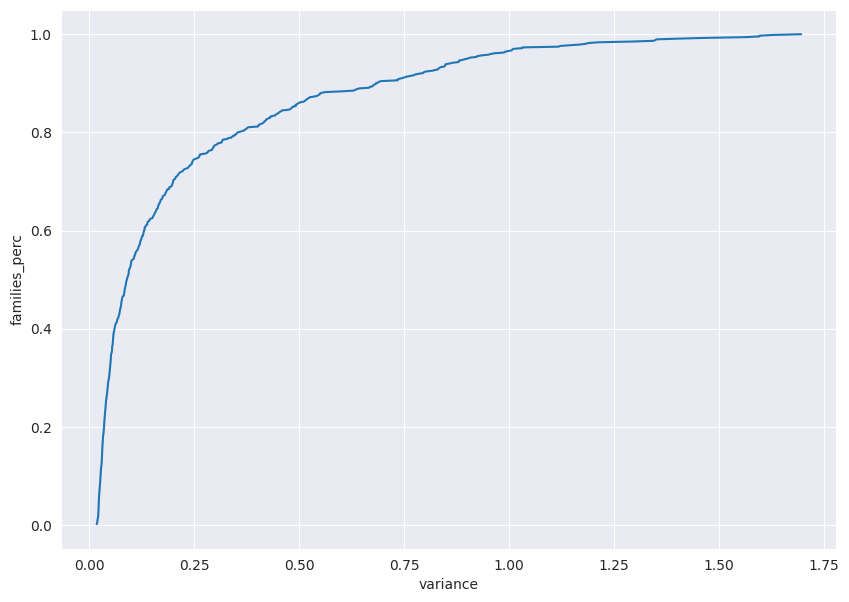

In [20]:
# Plot the distribution of first submissions over time
plt.figure(figsize=(10, 7))
sns.lineplot(df_variances, x="variance", y="families_perc")
plt.show()

In [21]:
df_variances = pd.DataFrame({"family": df_variances["family"], "variance": df_variances["variance"]})
df_variances_top = df_variances[df_variances["variance"] > 0.3].sort_values(by="variance", ascending=False)
families = df_variances_top["family"][:20]
df_variances_top.head()

,family,variance
669,balrok,1.696429
668,snojan,1.628920
667,griptolo,1.597762
666,stone,1.596723
665,daws,1.563488


In [22]:
# Extract the year from a timestamp t
def t_to_year(t):
    dt = pd.to_datetime(t, unit='s')
    return dt.year  #pd.Timestamp(f"{dt.year}-{dt.month}")


df_dt = df.copy()
df_dt['first_submission_date'] = df['first_submission_date'].apply(lambda t: t_to_year(t))

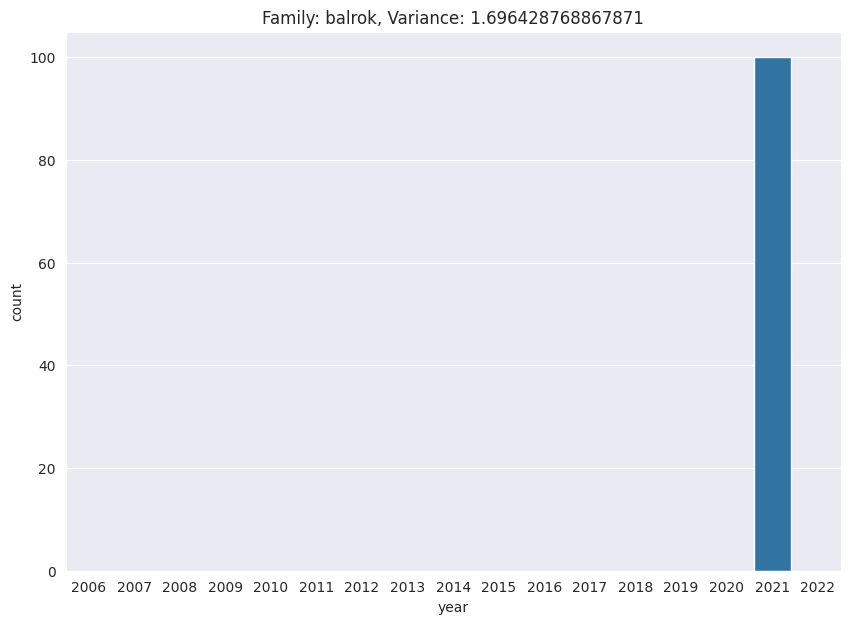

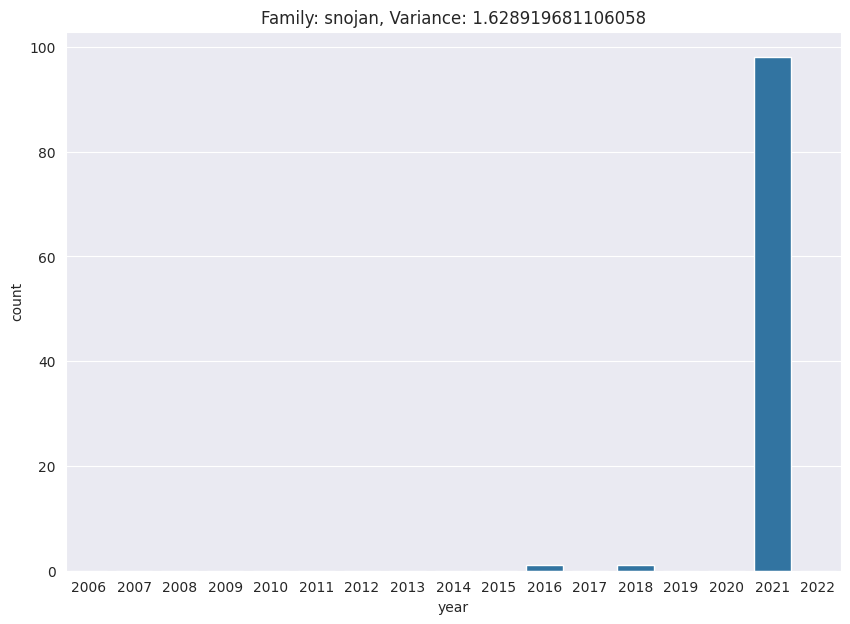

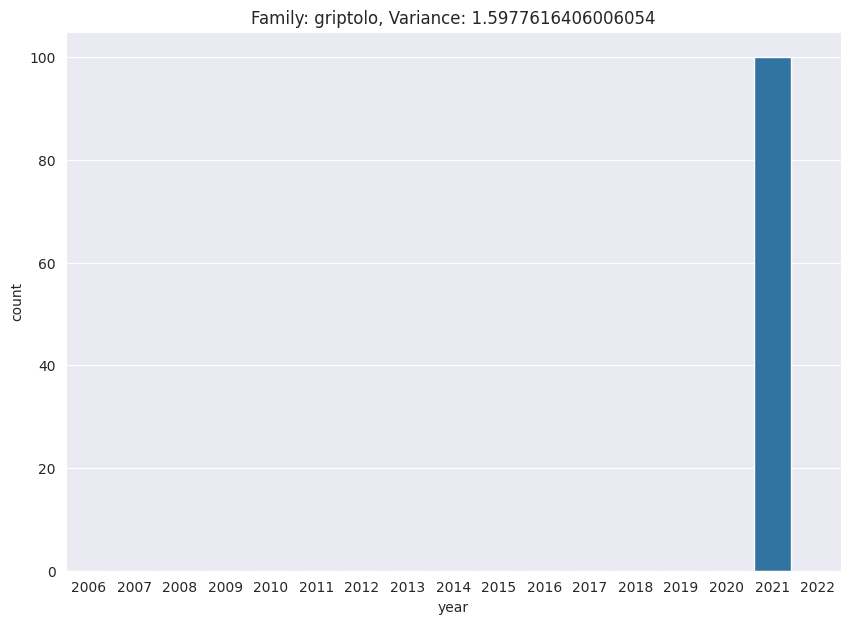

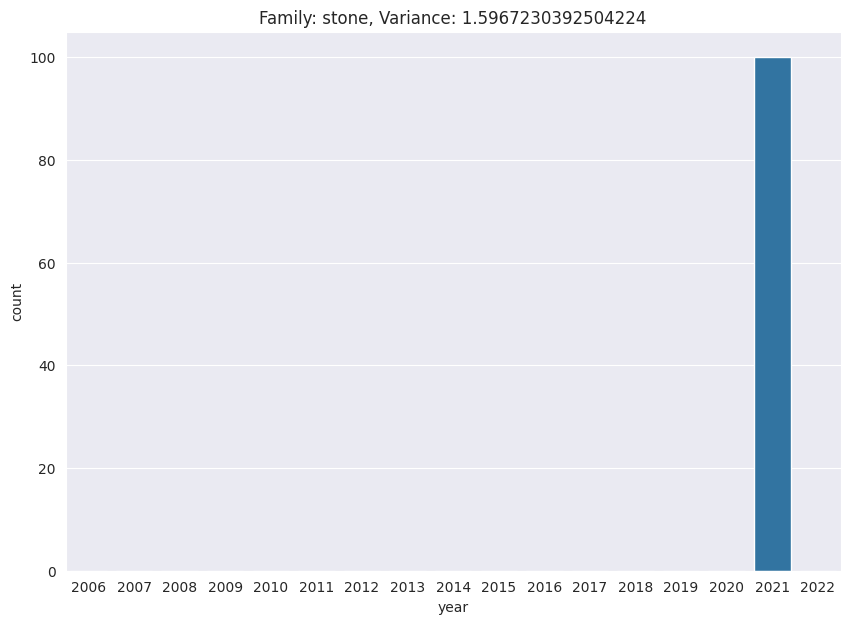

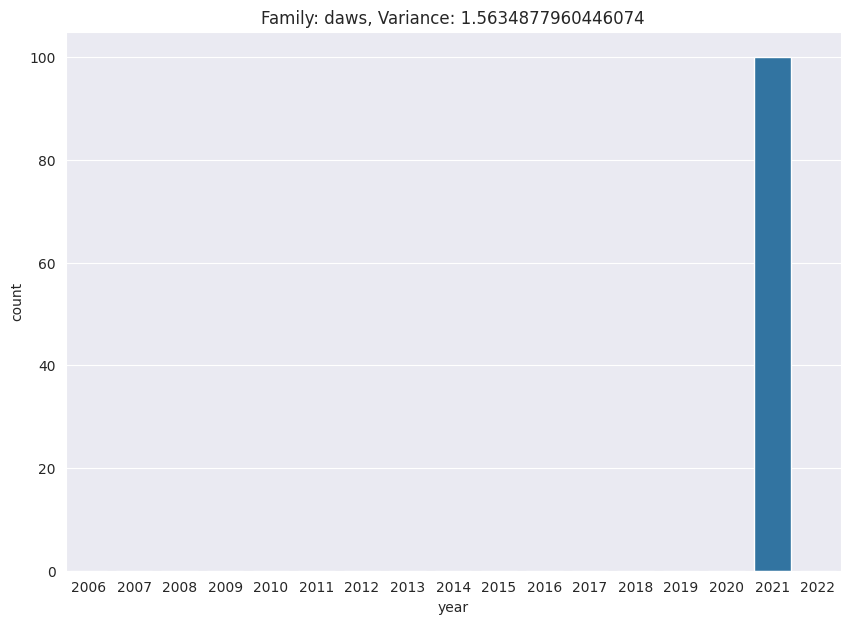

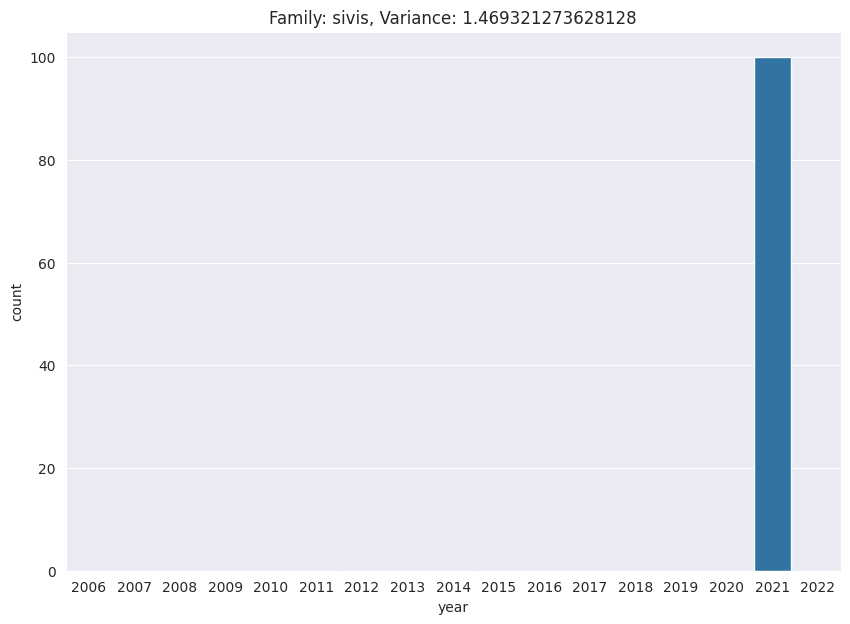

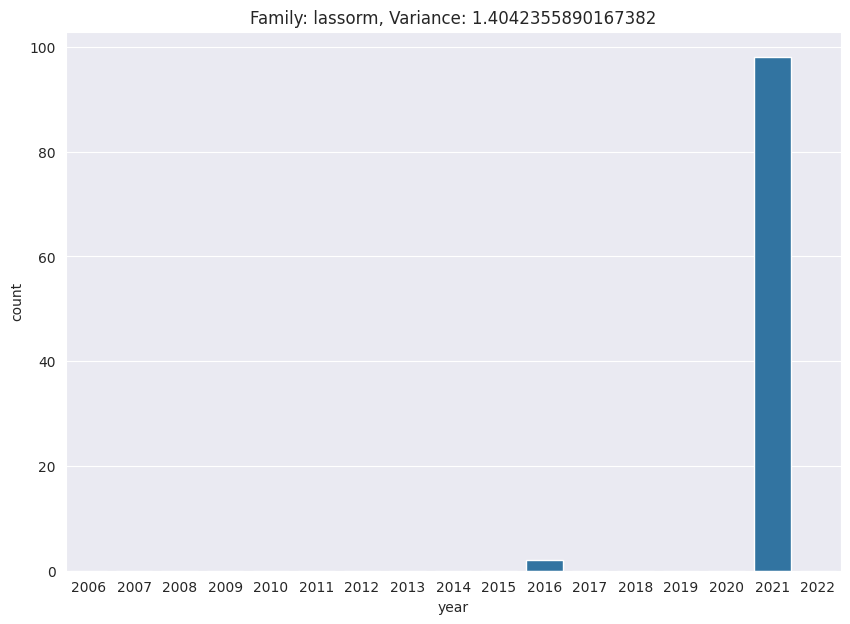

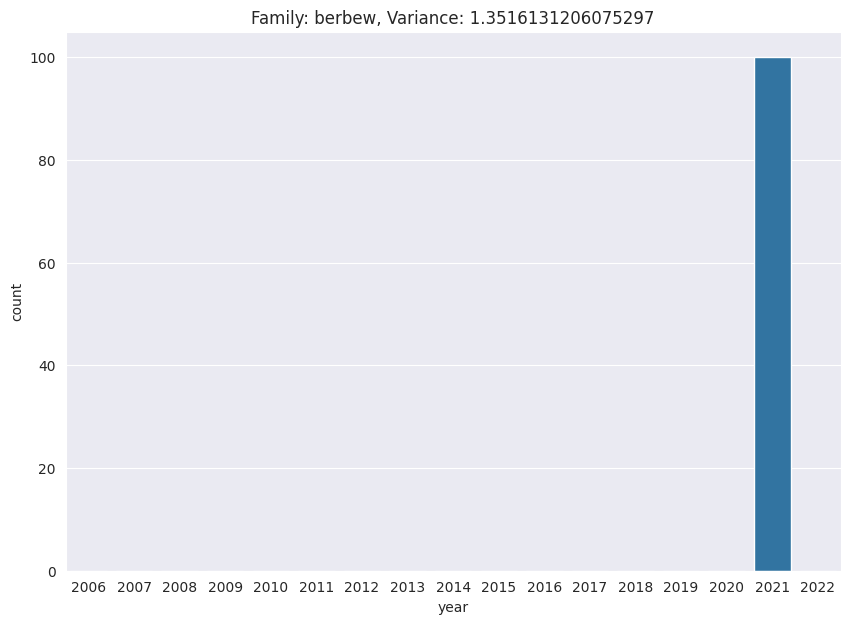

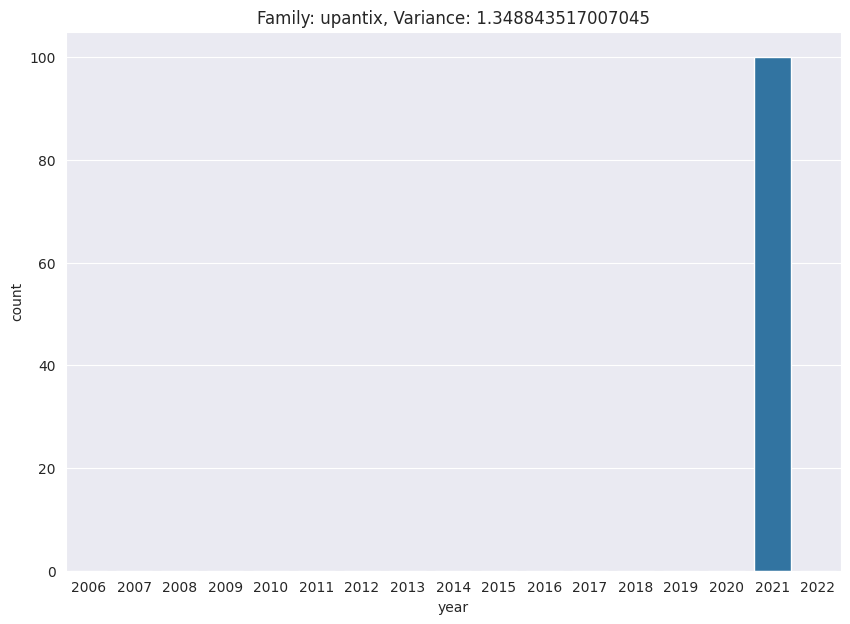

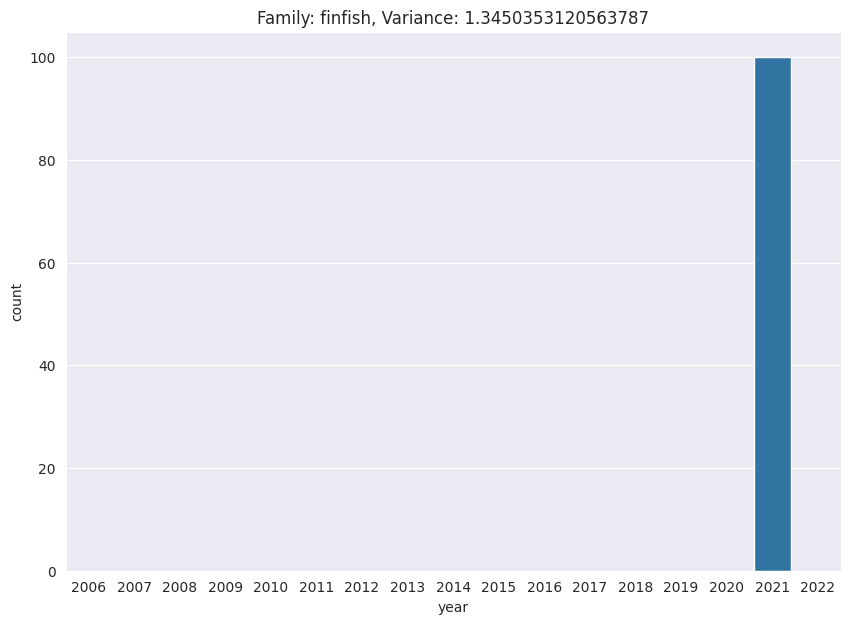

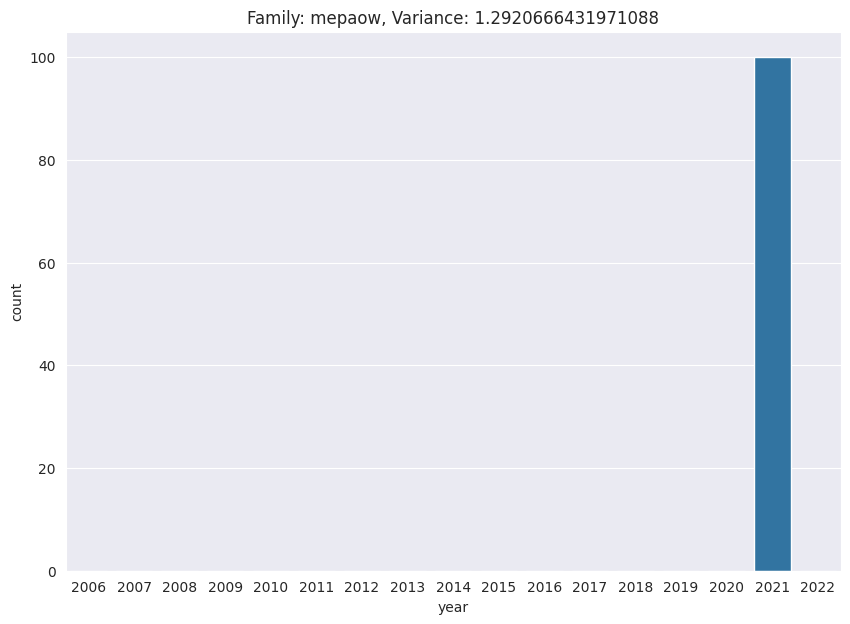

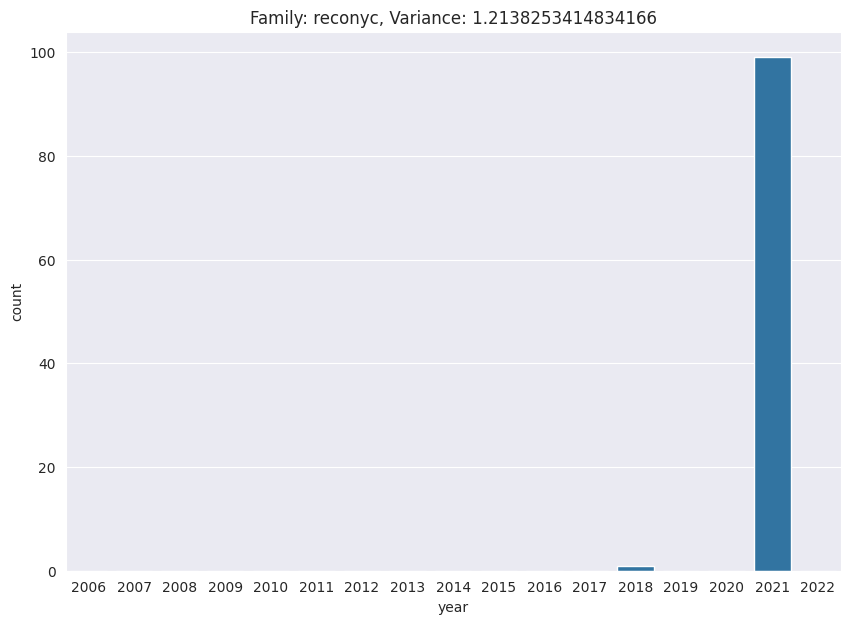

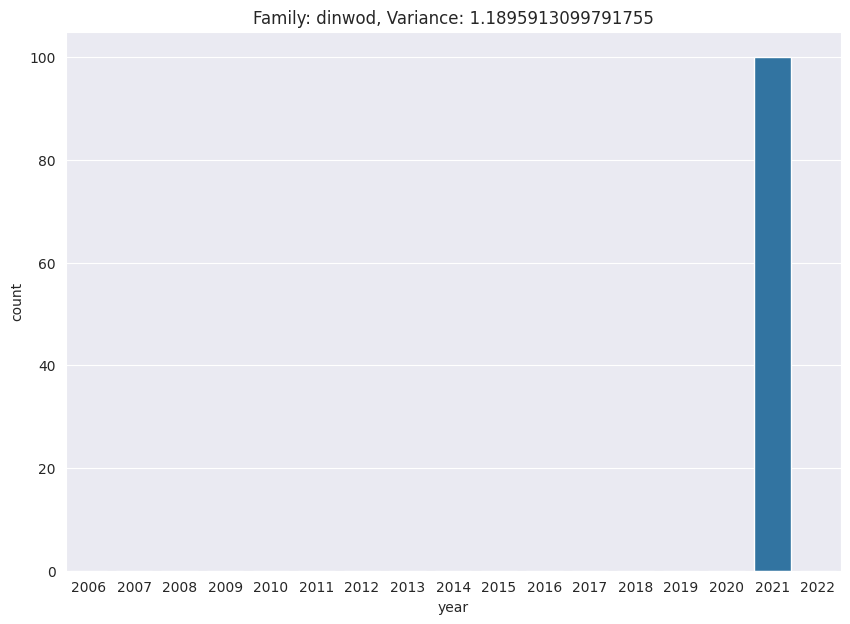

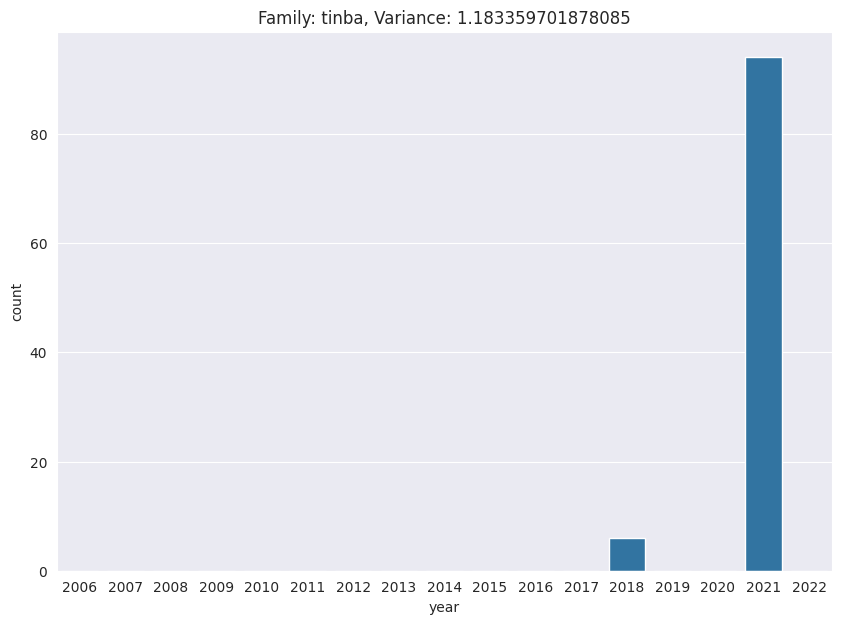

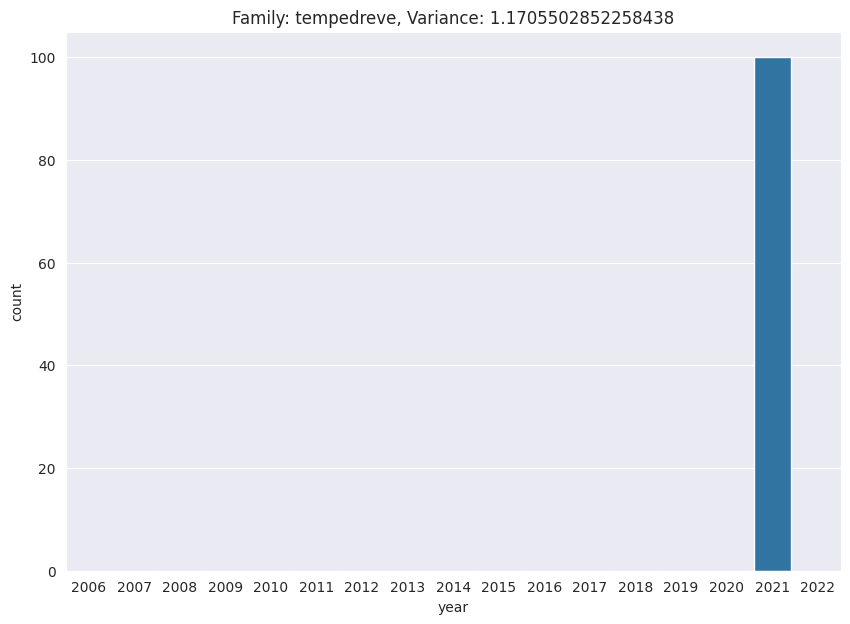

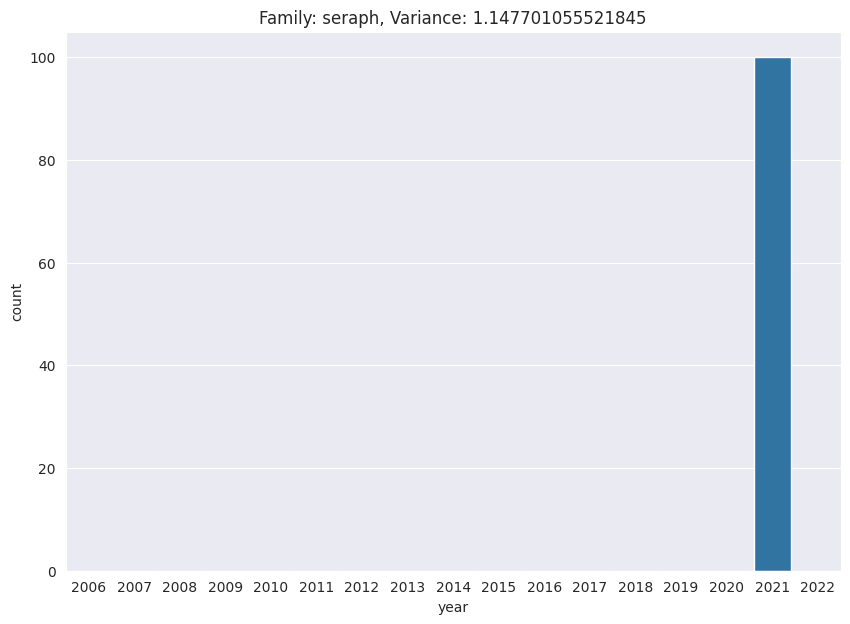

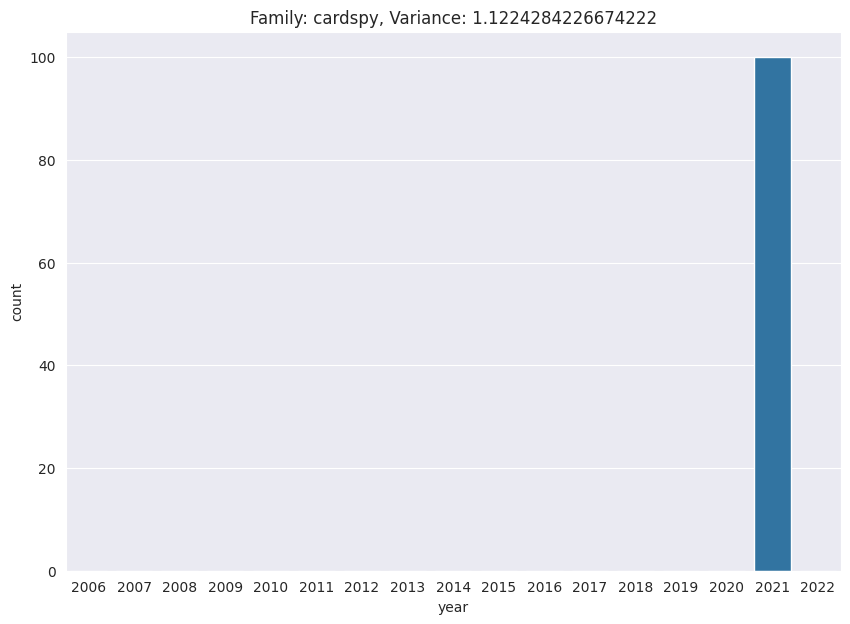

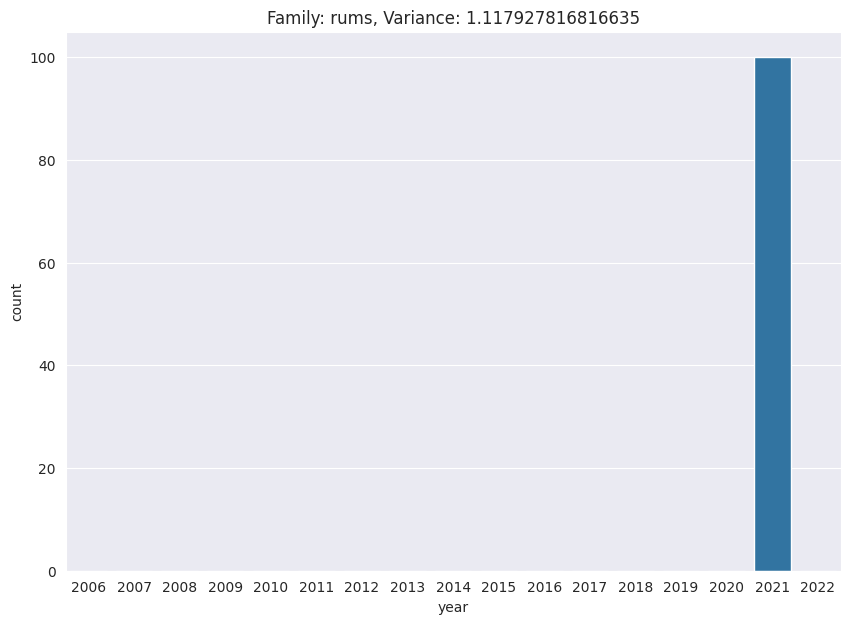

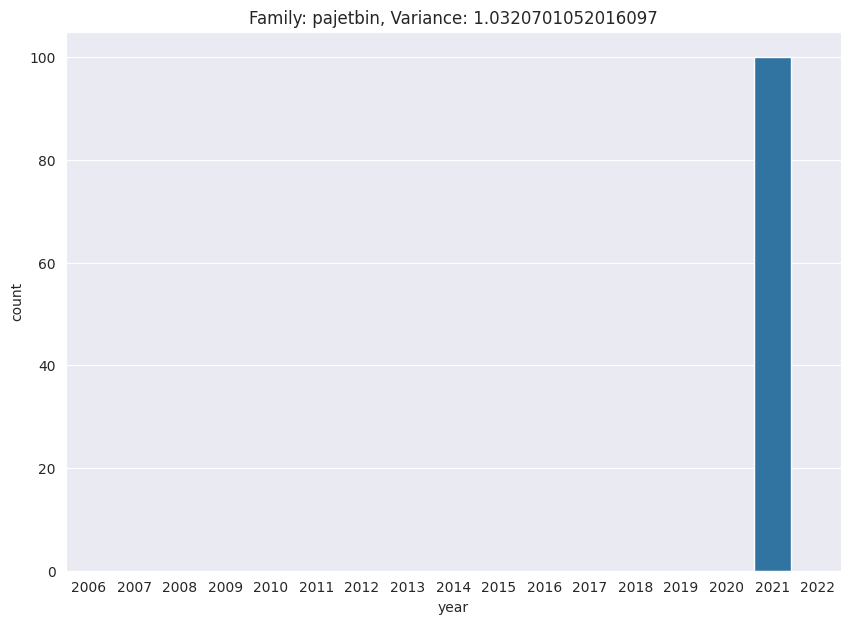

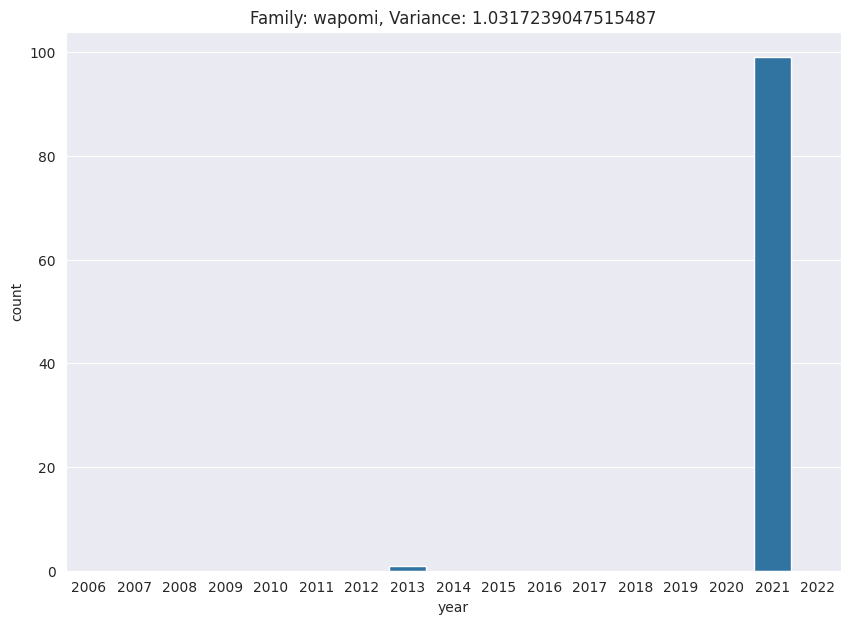

In [23]:
year_min = df_dt["first_submission_date"].min()
year_max = df_dt["first_submission_date"].max()

years_range = range(year_min, year_max + 1)  #pd.date_range(start=year_min, end=year_max, freq="Y")
df_dt_1 = df_dt.groupby(by=["family", "first_submission_date"]).size().reset_index(name='count')

for family in families:
    year_count = np.zeros(len(years_range))
    # Get the dataset portion where family is equal to the iteration one.
    family_data = df_dt_1[df_dt_1["family"] == family]
    # From each date compute the offset relative to year_count
    off = [y - year_min for y in family_data["first_submission_date"]]
    # Set each off cell with the respective count
    for index, value in zip(off, family_data["count"]):
        year_count[index] = value

    df_plot = pd.DataFrame({"year": years_range, "count": year_count})
    plt.figure(figsize=(10, 7))
    sns.barplot(data=df_plot, x="year", y="count")
    plt.title(f"Family: {family}, "
              f"Variance: {df_variances_top[df_variances_top['family'] == family]['variance'].iloc[0]}")
    plt.show()

In [24]:
def t_to_date(t):
    dt = pd.to_datetime(t, unit='s')
    return pd.Timestamp(f"{dt.year}-{dt.month}-{dt.day}")


df_corr = df.copy()
df_corr["first_submission_date"] = df_corr["first_submission_date"].apply(lambda t: t_to_date(t))
df_corr_1 = df_corr.groupby(by=["family", "first_submission_date"]).size().reset_index(name='count')

In [25]:
from scipy.stats import pearsonr

w_avg_timestamps = []
families = df_variances["family"].unique()
for family in families:
    family_data = df_corr_1[df_corr_1["family"] == family]
    timestamps = family_data["first_submission_date"].apply(lambda dt: dt.timestamp())
    w_avg = np.average(timestamps, weights=family_data["count"])
    w_avg_timestamps.append(w_avg)

df_avg_timestamps_f = pd.DataFrame({"family": families, "w_avg_timestamp": w_avg_timestamps})
df_variances_f = df_variances[df_variances["family"].isin(families)]

df_var_wat = pd.merge(left=df_avg_timestamps_f, right=df_variances_f, on="family")

print(pearsonr(df_var_wat["variance"], df_var_wat["w_avg_timestamp"]))

PearsonRResult(statistic=0.46342968410931346, pvalue=5.630758111934565e-37)


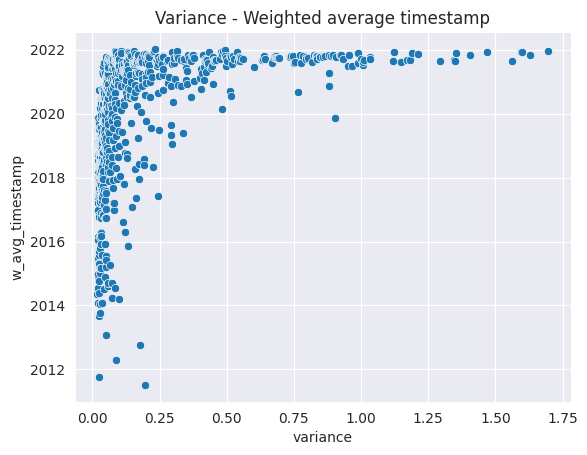

In [26]:
df_var_wat["w_avg_timestamp"] = df_var_wat["w_avg_timestamp"].apply(lambda t: pd.to_datetime(t, unit="s"))
sns.scatterplot(x=df_var_wat["variance"], y=df_var_wat["w_avg_timestamp"])
plt.title("Variance - Weighted average timestamp")
plt.show()

In [27]:
fsd = "first_submission_date"

df_cumulative = df.copy()
df_cumulative['first_submission_date'] = (df['first_submission_date']
                                .apply(lambda t: pd.to_datetime(t, unit="s"))
                                .apply(lambda dt: pd.Timestamp(f"{dt.year}-{dt.month}-{dt.day}")))

df_cumulative = df_cumulative.groupby(by=["family"]).min()

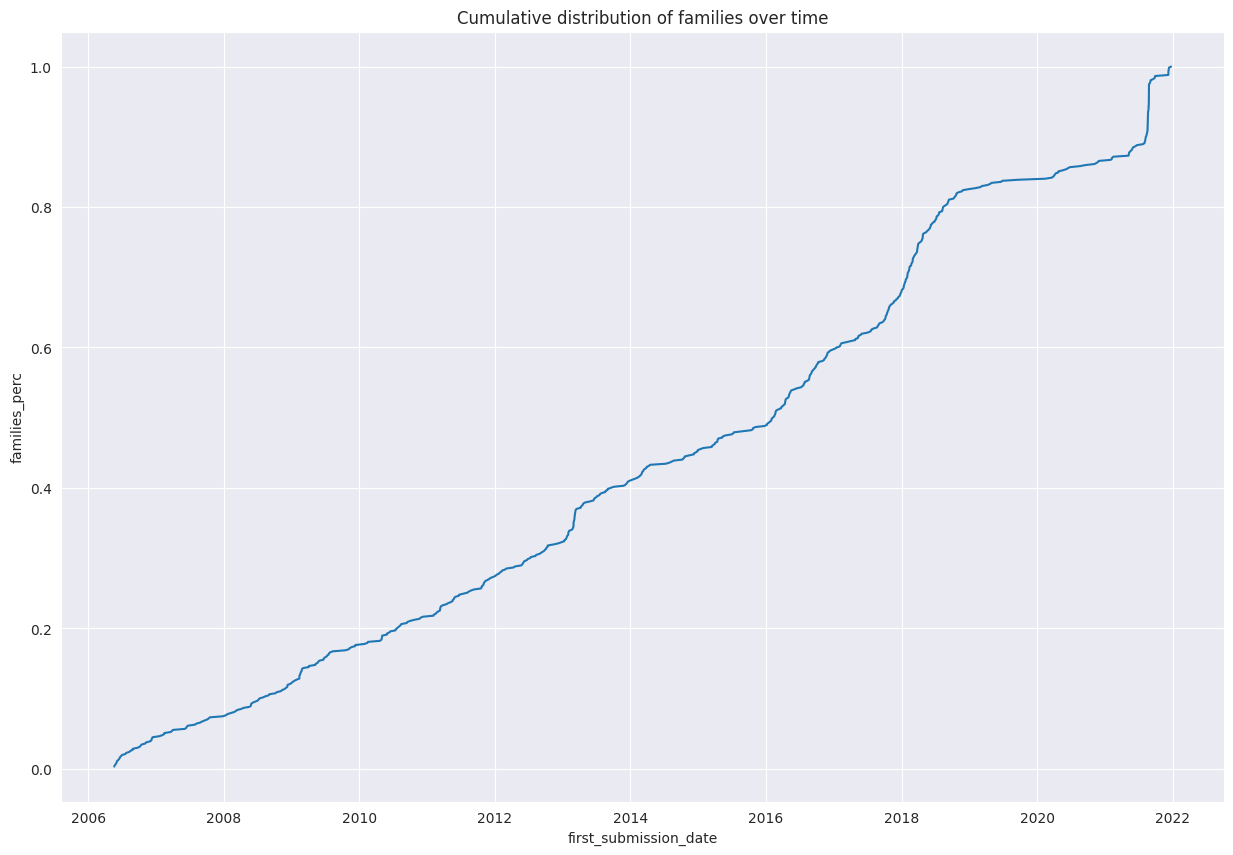

In [28]:
n = len(df_cumulative)
# For each timestamp, get the number of families previously discovered
df_cumulative['families_perc'] = df_cumulative['first_submission_date'].apply(
    lambda t: len(df_cumulative[df_cumulative['first_submission_date'] <= t]) / n
)

# Sort the submission date in ascending order
df_cumulative = df_cumulative.sort_values(by="first_submission_date")

# Plot the distribution of first submissions over time
plt.figure(figsize=(15, 10))
plt.title("Cumulative distribution of families over time")
#plt.axvline(x=pd.Timestamp("2021-03-19"), color='red', linestyle='--', label='x=10')
sns.lineplot(df_cumulative, x="first_submission_date", y="families_perc")
plt.show()

In [29]:
timestamp_to_datetime = lambda t: pd.to_datetime(t, unit='s')
datetime_to_timestamp = lambda t: t.timestamp()


# Fit linear regression
def lin_reg_fit(df_split):
    timestamps = df_split["first_submission_date"].apply(
        lambda t: datetime_to_timestamp(t)
    )
    X, y = (np.array(timestamps).reshape(-1, 1), np.array(df_split["families_perc"]))
    return LinearRegression().fit(X, y), X, y


# Plot regressions 
def plot_regressions(reg_data, max_slope_idx):
    fig, ax = plt.subplots()
    plt.title("Window-based linear regression")

    for i in range(len(reg_data)):
        reg, X, _ = reg_data[i]
        X1 = timestamp_to_datetime(X.ravel())
        df1 = pd.DataFrame({"first_submission_date": X1, "families_perc": reg.predict(X)})
        #sns.scatterplot(cumulative_df, x="first_submission_date", y="families_perc")
        sns.lineplot(df1, x="first_submission_date", y="families_perc", 
                     linewidth=3 if i == max_slope_idx else 1, ax=ax)
    plt.show()

In [30]:
from sklearn.linear_model import LinearRegression

df1 = df.copy()
df1['first_submission_date'] = df1['first_submission_date'].apply(lambda t: timestamp_to_datetime(t))

# Min and maximum dates
date_min = df1["first_submission_date"].min()
date_max = df1["first_submission_date"].max()

total_duration = date_max - date_min

def window_linear_regression(n_windows=2):
    window_size = total_duration / n_windows

    windows = [i * window_size for i in range(n_windows + 1)]
    splits = [df_cumulative[
                  (df_cumulative["first_submission_date"] - date_min >= windows[i - 1]) &
                  (df_cumulative["first_submission_date"] - date_min < windows[i])]
              for i in range(1, len(windows))]

    regressions_data = []
    slopes = []
    for split in splits:
        regression_data = lin_reg_fit(split)
        regressions_data.append(regression_data)
        slopes.append(regression_data[0].coef_[0])

    index_max = np.argmax(slopes)
    plot_regressions(regressions_data, index_max)

In [31]:
%matplotlib inline
from ipywidgets import *
import matplotlib as mpl
#mpl.use('Qt5Agg')  # or can use 'TkAgg', whatever you have/prefer

n_windows = date_max.year - date_min.year
interact(window_linear_regression, w=(2, n_windows, 1))

interactive(children=(IntSlider(value=2, description='n_windows', max=6, min=-2), Output()), _dom_classes=('wi…

<function __main__.window_linear_regression(n_windows=2)>